## Import necessary modules

Every Jupyter Notebook requires the path to the KineticAssembly_AD modules (.py files in the root directory) to be mentioned. This can be done by adding the path to the 'PATH' variable of the system environment. 

Additonal modules are also imported which are required to run any analysis.

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
path_to_repo = "C:\\Users\\denys\\AMGEN\\"
#Insert your path here
# path_to_repo=""
sys.path.append(path_to_repo)


import copy
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim    #Import required python modules explicitly
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

## Setup Reaction Network
Before we begin to run a simulation, we need to create a Reaction Network that stores all the parameters required to run a simulation and other routines. The Reaction Network can be created by reading an input file. More information on how to create an input file can be found in the User Guide. 

Here a simple trimer model is used to run a simulation.
#### Read the corresponding input file and call the ReactionNetwork class

In [2]:
base_input = './trimer.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['default_assoc', 1.0]
[(0, {'struct': <networkx.classes.graph.Graph object at 0x00000297C7C071D0>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (1, {'struct': <networkx.classes.graph.Graph object at 0x00000297C7C074E0>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (2, {'struct': <networkx.classes.graph.Graph object at 0x00000297C7B72A90>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})]
New node added - Node index: 3 ; Node label: AB 
New node added - Node index: 4 ; Node label: AC 
New node added - Node index: 5 ; Node label: BC 
New node added - Node index: 6 ; Node label: ABC 
Reaction Network Completed


## Checking reaction network

The ReactionNetwork is a networkx object which creates a graph network with each node as species that can be present in the system according to the binding rules given in the input file. Each node has a unique index number that can be used to access attributes stored for that species. Each edge represents a reaction and is associated with a unique reaction_id, on and off rates and the dG value for that reaction.


After creating a Reaction Network we can looping over all network nodes to check if all species are created
Creating a dictionary for later reference. This dictionary holds the reactants as keys and values as the reaction index

In [3]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr

print("Species present in the Reaction Network: ")
print("%3s  %2s  %2s" %("Index","--",'Species'))
for n in rn.network.nodes():
    print("%3d  %4s  %-6s" %(n,"--",gtostr(rn.network.nodes[n]['struct'])))
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print()
print("Total Number of Reactions: ",rn._rxn_count)
print("Total Number of Species: ",len(rn.network.nodes()))
        
# Dictionary that stores source,destination of an edge and maps it to its unique id
#Key : (First Reactant, Product)
#Value : (Reaction_id)
print()
print(uid_dict)

Species present in the Reaction Network: 
Index  --  Species
  0    --  A     
  1    --  B     
  2    --  C     
  3    --  AB    
  4    --  AC    
  5    --  BC    
  6    --  ABC   

Total Number of Reactions:  6
Total Number of Species:  7

{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


## Set Initial conditions for the association rates
The next step is to define the initial conditions for the simulation. The initial concentrations are specified from the input file. However, the initial value of the association rates can be specified either through the input file 

From the user_input file, currently the code only allows 1 value to be read (from default_assoc parameter).

To set starting rates to different values the next code block takes in a list/array of all rxn rates and updates them in the reaction network object.

In [4]:
#Define an empty torch tensor with length equal to number of reactions
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()

# Create a list of reaction rates that you want as the starting condition. 
# The list should be of the same length as the number of reactions.
new_kon = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5]
# new_kon = [0.27616573377648024, 0.27616573377648024, 0.27616573377648024, 1.5585519229885603, 1.5585519229885603, 1.5585519229885603]

update_kon_dict = {}
for edge in rn.network.edges:
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 5}
{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 3}
{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}
{'k_on': 5, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}
{'k_on': 5, 'k_off': None, 'lc

## Define the VectorizedRxnNet class
This takes the corresponding rxn network class as input and creates tensor arrays for all parameters values required for running a simulation.



In [5]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')
vec_rn.reset()

Reaction rates:  tensor([5., 5., 5., 5., 5., 5.], dtype=torch.float64, grad_fn=<CopySlices>)
dGs:  tensor([-20., -20., -20., -40., -40., -40.], dtype=torch.float64)
Species Concentrations:  tensor([100., 100., 100.,   0.,   0.,   0.,   0.], dtype=torch.float64)
Shifting to device:  cpu


## Create the VecSim class to run a simulation
Takes the VecRxnNet  object as input. The simulation runtime is set by the 'runtime' argument. (Units - sec)

In [6]:
runtime = 1e4
sim = VecSim(vec_rn, runtime, device='cpu')


Using CPU


# Run a Simulation
### Input Parameters: 
conc_scale: Controls the conc step at each iteration. Since the numerical integration is not performed over fixed time steps but over fixed conc. steps. For e.g. for a value of 1uM, at each iteration step a total of app. 1uM is reacted (includes all species). Can be run using the default value. A general rule is use conc_scale = 0.01 * Max_yield

conc_thresh: This can be used to periodically decrease the conc_scale parameter. After each iteration if the conc_scale is greater than the conc_thresh, then the conc_scale is decreased by mod_factor. Can be run using the default value. 

mod_bool: This argument is necessary to fix the mass balance criteria. Sometimes if the conc_scale is large, then the simulation can lead to a higher consumption of a particular species which is very low in conc, and create more of this species out of nothing. Default value:True

verbose : Print output and progress of simulation

yield_species : The species whose yield is to be tracked and returned to the optimzer. 



In [7]:
y = sim.simulate(conc_scale=1e-2,conc_thresh=1e-2,mod_bool=True,verbose=True,yield_species=6)

Start of simulation: memory Used:  63.3
Simulation rates:  tensor([5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00,
        1.0306e-02, 1.0306e-02, 1.0306e-02, 2.1242e-11, 2.1242e-11, 2.1242e-11],
       dtype=torch.float64, grad_fn=<ExpBackward>)
Memory Used: 64.9
RAM Usage (GB): 8.987335205078125
Current Time: tensor(0.0014, dtype=torch.float64, grad_fn=<AddBackward0>)
Memory Used: 64.6
RAM Usage (GB): 8.948394775390625
Current Time: tensor(13.1176, dtype=torch.float64, grad_fn=<AddBackward0>)
Final Conc Scale:  0.01
Number of steps:  23324
Next time larger than simulation runtime. Ending simulation.
Memory Used:  64.8
RAM Usage (GB):  8.979000091552734
Final Yield:  tensor(1.0000, dtype=torch.float64, grad_fn=<DivBackward0>)


## Plot the conc. of all species vs time

We can plot the concentration vs time data for all species. We can choose which species concentration is to be plotted using the nodes_list variable.

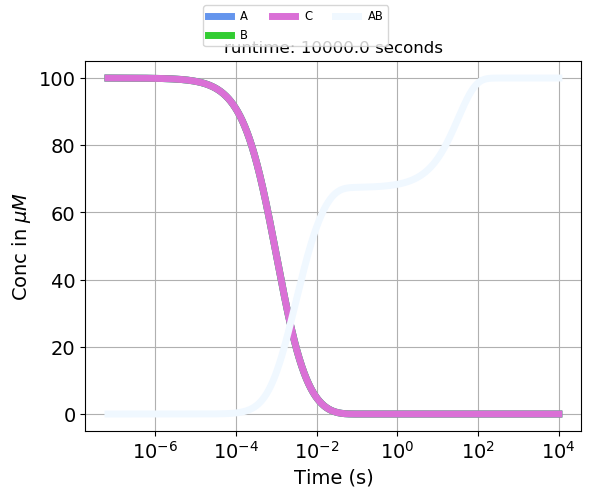

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()

#Choose which species needs to be plotted
nodes_list = ['A','B','C','AB','BC','AC','ABC']

sim.plot_observable(nodes_list, ax=ax,legend=False,seed=201,lw=5)
ax.set_title("runtime: " + str(runtime) + " seconds")
handles,labels = ax.get_legend_handles_labels()
ax.set_xscale("log")
fig.legend(handles,nodes_list,loc='upper center',fancybox=True,ncol=3,fontsize='small',markerscale=1.0)
ax.grid(which="major",axis="both")

### The following code can be used to store the Conc vs Time data for the final complex

It can also be modified to store data for all species

In [9]:
def convert_time_interval(time,conc,time_int=0.1):
    start_time=time[0]
    time_array = []
    conc_array = []
    for i in range(len(time)):
        new_time=time[i]
        ts = new_time/start_time
        if ts>=time_int:
            time_array.append(time[i])
            conc_array.append(conc[i])
            start_time=new_time
    return(time_array,conc_array)
        
    


Before storing, the data can be smoothened by selecting only a fixed separation of time intervals to store. Its useful in removing rougher area which can arise due to a high conc_scale parameter 

In [10]:
time_arr = np.array(sim.steps)
complx_conc = np.array(sim.observables[12][1])

sel_time = (time_arr >= 1e-4)
sel_indx = np.argwhere(sel_time)[0][0]

filter_time,filter_conc = convert_time_interval(time_arr[sel_indx-1:],complx_conc[sel_indx-1:],time_int=1.15)
final_time = np.concatenate((time_arr[:sel_indx],filter_time[:]))
final_conc = np.concatenate((complx_conc[:sel_indx],filter_conc[:]))

KeyError: 12

In [ ]:
with open("Conc_Profile_Trimer","w") as fl:
    fl.write("#Timestep\tConc\n")
    for i in range(len(final_time)):
        fl.write("%10.9f\t%10.9f \n" %(final_time[i],final_conc[i]))
        

### Calculate Trapping Factor

Using the cleaned up time and concentration data, we calculate the differential - dC/dln(t) and plot it. 


In [ ]:
def calc_slope(time,conc,mode='delta'):
        #There are 3 modes to calc slopes
        #Mode 1 - "delta" : mode which is just ratio of finite differences
        #Mode 2 - "log" : Gradient calc using numpy gradient function, but time is in logspace
        #Mode 3: "regular" : Gradient calc with time in normal space

        if mode=="delta":
            slopes=[]
            for i in range(len(time)-1):
                delta_c = conc[i+1]=conc[i]
                delta_t = np.log(time[i+1]-time[i])

                s = delta_c/delta_t
                slope.append(s)

            return(slopes)
        elif mode=='log':
            l_grad = np.gradient(conc,np.log(time))
            return(l_grad)
        elif mode == "regular":
            grad = np.gradient(conc,time)
            return(grad)

        
#Uncleaned version - GRAD1
l_grad = calc_slope(final_time,final_conc,mode='log')
fig,ax2 = plt.subplots()

ax2.plot(final_time,l_grad,linestyle='-',marker='.',alpha=0.6,color='crimson')
ax2.set_xscale("log")

**Isolate the inflection points**

I do this by visualizing and handpicking the ranges that cover the two peaks. (I tried automating this but sometimes the numerical instabilities does not give the correct ratios)



In [ ]:
actual_l_grad = l_grad
actual_time = final_time

#Finding time points by just visual picking
first_peak_mask = actual_time<1
first_peak_indx = np.argmax(actual_l_grad[first_peak_mask])
first_peak = actual_time[first_peak_mask][first_peak_indx]

second_regime_mask = (actual_time>1)
second_peak_indx = np.argmax(actual_l_grad[second_regime_mask])
second_peak = actual_time[second_regime_mask][second_peak_indx]


valley_mask = (actual_time>first_peak) & (actual_time<second_peak)
min_grad = np.argmin(actual_l_grad[valley_mask])
# third_regime_mask = (actual_time>1e6)
# third_peak_indx = np.argmax(actual_l_grad[third_regime_mask])
# third_peak = actual_time[third_regime_mask][third_peak_indx]

# time_bounds = [first_peak,second_peak,third_peak]
time_bounds = [first_peak,second_peak]


print('t1 = %.3f s | t2 = %.3f s' %(time_bounds[0],time_bounds[1]))
lag_time = np.log(time_bounds[1]/time_bounds[0])

print("Trapping Factor: ",lag_time)


For higher order N-mers, follow the same routine. In case of multiple peaks, which can happend due to multiple steady-state trapped regimes, the trapping factor is calculate as the ratio between the time_point of the lastpeak to the first peak. 